In [1]:
import keras
import tensorflow as tf
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [2]:
from scipy.io import loadmat
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

data = np.genfromtxt('TrackTrainingSetArSc.csv',delimiter=' ', skip_header=1)
print(("Rozmiar zestawu treningowego = %d x %d ")%(data.shape[0], data.shape[1]))
datapd = pd.read_csv('TrackTrainingSetArSc.csv', sep=' ', header=0)
datapd.head()

Rozmiar zestawu treningowego = 51796 x 21 


,p,px,py,pz,q,enDep,Ndedx,pFirstX,pFirstY,pFirstZ,...,pFirstBy,pFirstBz,pLastX,pLastY,pLastZ,pLastBx,pLastBy,pLastBz,qOverPXZ,nMaxPoint
0,35.3962,1.67535,-0.135090,35.3563,1,1.47675,149,13.8034,-1.74045,-106.713,...,-0.945703,0.014367,70.4970,-5.03450,727.355,0.0,0.0,0.0,1.776860e-08,163
1,27.3294,1.72625,-0.092073,27.2747,1,1.28169,145,18.9224,-1.51537,-103.926,...,-0.962149,0.011925,89.8605,-4.22046,691.489,0.0,0.0,0.0,1.463870e-08,158
2,12.4532,1.29021,-0.343452,12.3815,1,1.44962,150,24.8742,-12.74300,-109.514,...,-0.925083,0.114150,160.6840,-37.63010,725.896,0.0,0.0,0.0,1.754720e-08,163
3,10.7554,1.39227,0.072020,10.6646,1,1.44501,147,33.5505,2.74863,-110.061,...,-0.878054,-0.025127,197.0500,9.07875,725.320,0.0,0.0,0.0,1.977520e-08,160
4,17.3145,1.11973,-0.144980,17.2776,1,1.46821,127,12.9113,-3.92648,-100.471,...,-0.997326,0.028064,100.8290,-10.90940,726.866,0.0,0.0,0.0,1.816090e-08,154


Spis treści.<br>
1. Wstęp.
2. Teoria.
    1. Uczenie maszynowe:
            a) nadzorowane (w tym sieci neuronowe)
            b) nienadzorowane
    2. Pakiet Keras
    3. Eksperyment NA61/SHINE (http://shine.web.cern.ch/)
    4. Detektory projekcji czasowej (Time Projection Champer TPC).
    5. Rekonstrukcja sladów w eksperymencie NA61/SHINE.
    6. Potencjalna liczba punktów w komorach TPC - bieżąca implementacja.
3. Potencjalna liczba punktów w komorze TPC - implementacja algorytmu uczenia maszynowego.
    1. Zestaw treningowy.
    2. Rozkłady cech i podstawowe zależności.
    3. Inżynieria cech.
    4. Implementacja sieci neuronowej oraz analiza danych.
4. Podsumowanie.

__23 maj 2019 KS:__ Proszę zaznajomic się z materiałami, które Panu udostepniłam. Proszę wykonać rysunki: 
1. Rozkład każdej z 20-tu cech (histogramy 1-d)
2. Zależność NMaxPoint (kolumna 20 na osi y) vs cecha dla każdej cechy (20 rysunków, histogramy 2-d).

<font color='red'> KS lipiec 2019</font>: </br>
1. W histogramach 1D proszę stostować podpis pod osią X. Należy dodać jednostki do cech. Te związane z pędem i energią: GeV, położeniem: cm, polem magnetycznym: tesla.
2. Proszę stosować polskie nazwenictwo na rysunkach (tytuły, opisy osi itp.)

In [34]:
jednostki = {'p': ' [GeV]', 
             'px': ' [GeV]', 
             'py': ' [GeV]', 
             'pz': ' [GeV]',
             'q': '', 
             'enDep': '',
             'Ndedx': '',
             'pFirstX': '',
             'pFirstY': '',
             'pFirstZ': '',
             'pFirstBx': '',
             'pFirstBy': '',
             'pFirstBz': '',
             'pLastX': '',
             'pLastY': '',
             'pLastZ': '',
             'pLastBx': '',
             'pLastBy': '',
             'pLastBz': '',
             'qOverPXZ': '',
             'nMaxPoint': ''}
print(datapd.keys())

Index(['p', 'px', 'py', 'pz', 'q', 'enDep', 'Ndedx', 'pFirstX', 'pFirstY',
       'pFirstZ', 'pFirstBx', 'pFirstBy', 'pFirstBz', 'pLastX', 'pLastY',
       'pLastZ', 'pLastBx', 'pLastBy', 'pLastBz', 'qOverPXZ', 'nMaxPoint'],
      dtype='object')


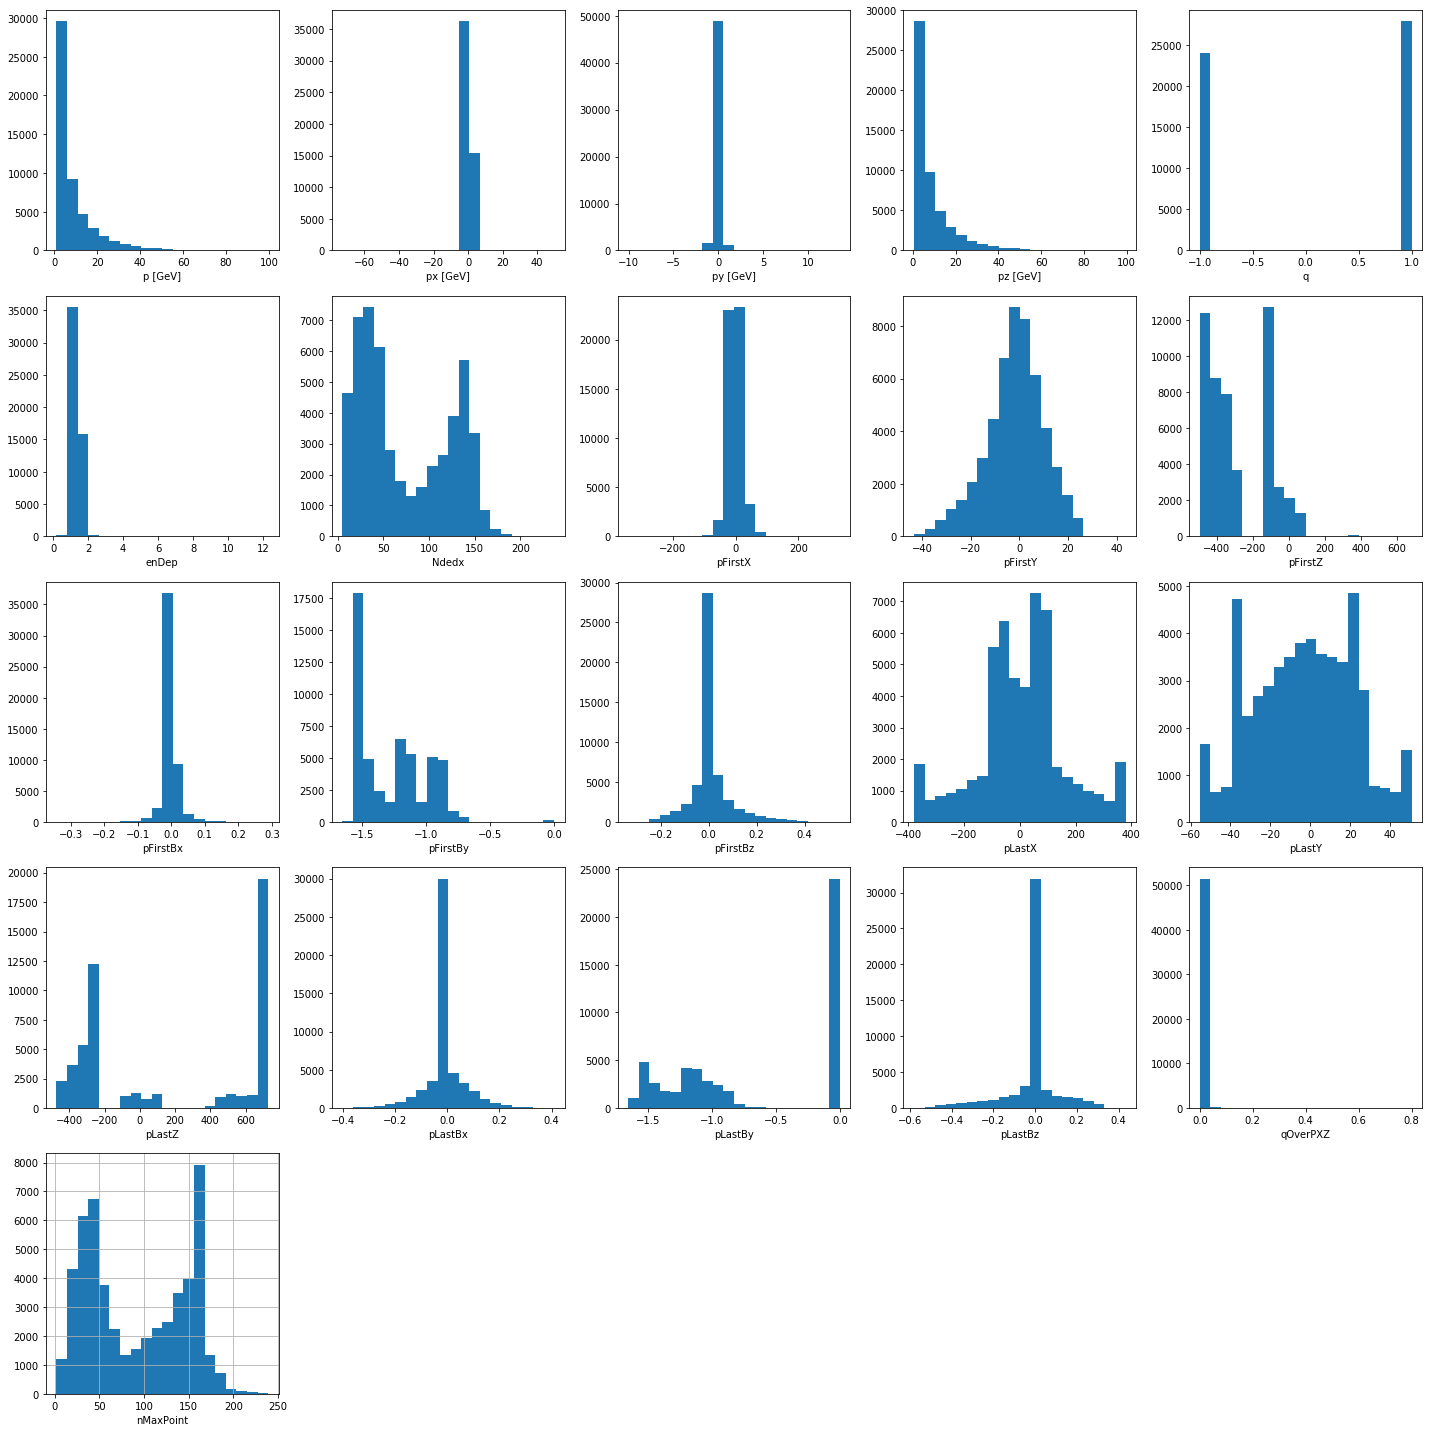

In [35]:

i=1
plt.figure(figsize=(20,20))
for key in datapd.keys():
    plt.subplot(5,5,i)
    i+=1
    plt.hist(datapd[key], bins=20)
    plt.xlabel(str(key) + jednostki[key])
    plt.tight_layout()
plt.grid()
plt.show()

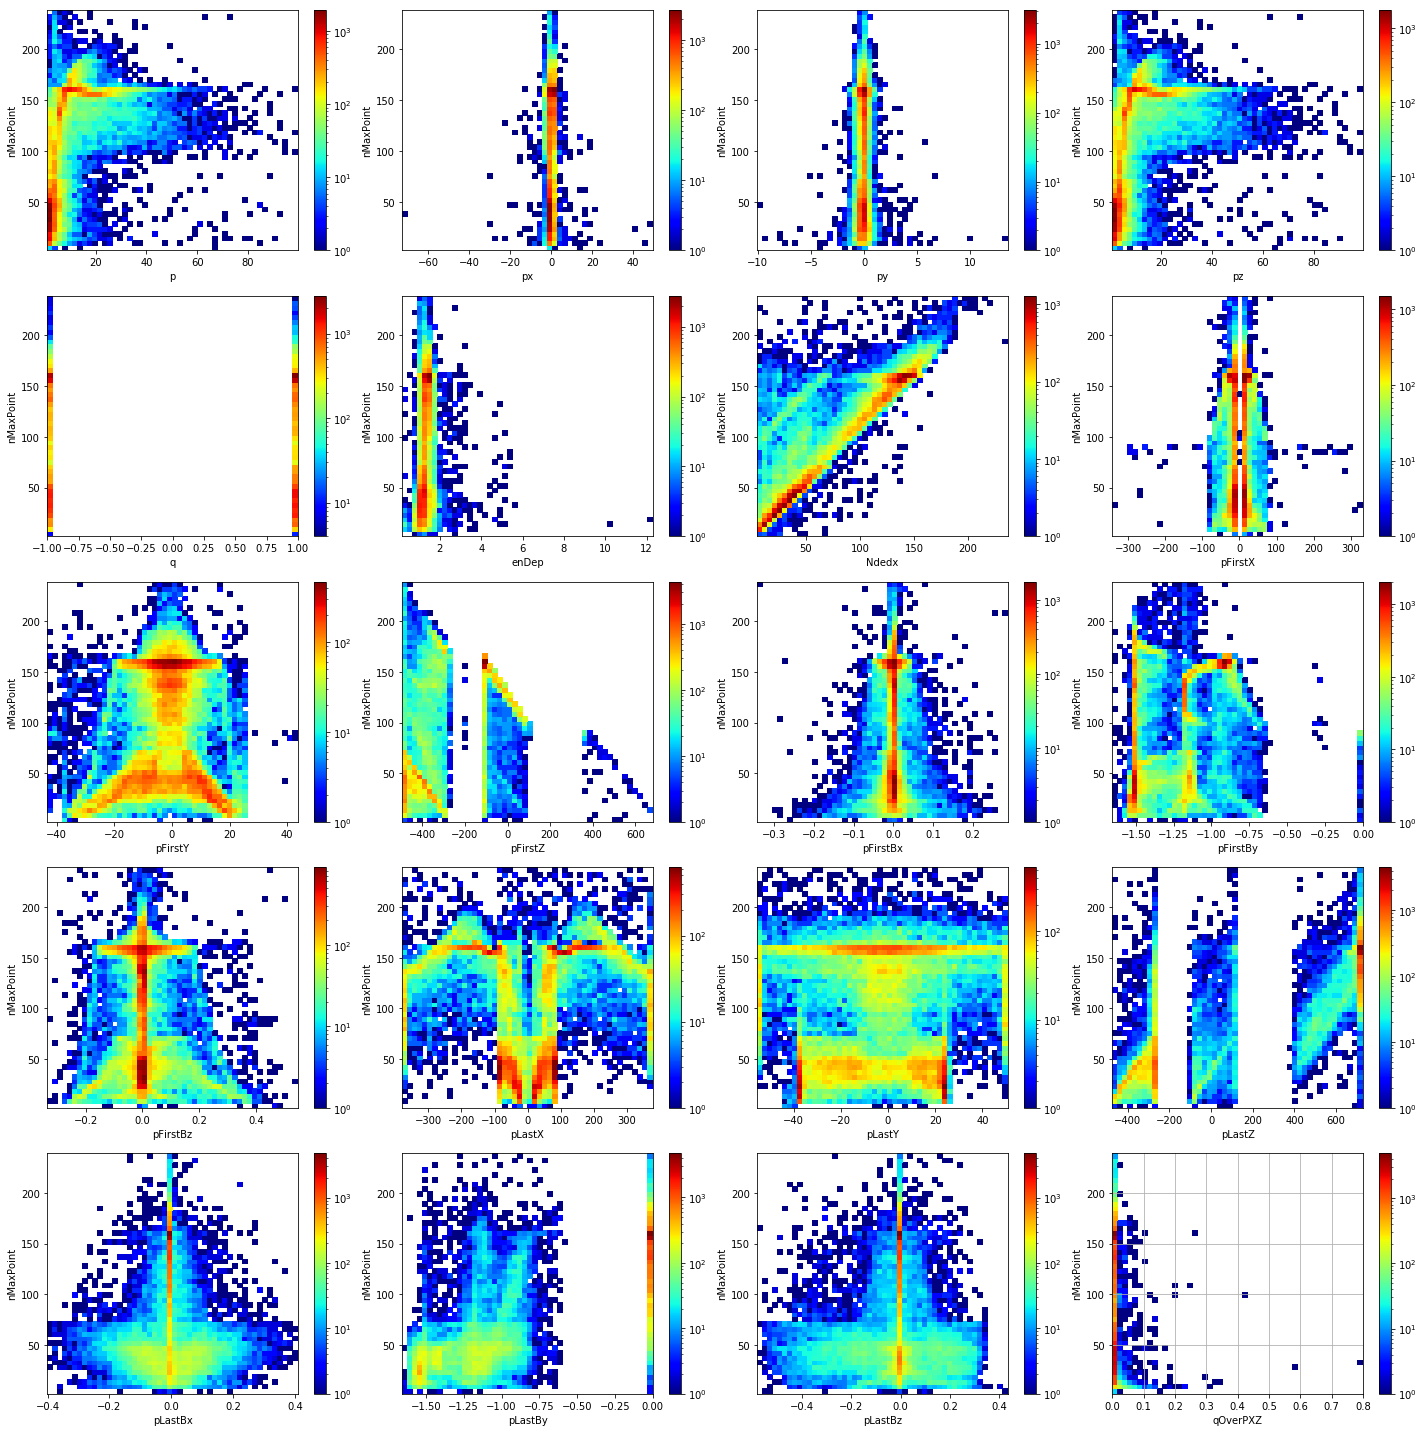

In [37]:
from matplotlib.colors import LogNorm

i=1
plt.figure(figsize=(20,20))
for key in datapd.drop("nMaxPoint", axis=1).keys():
    plt.subplot(5,4,i)
    i+=1
    plt.hist2d(x=datapd[key], y=datapd['nMaxPoint'], bins=50, cmap='jet', norm=LogNorm())
    plt.xlabel(key)
    plt.ylabel('nMaxPoint')
    plt.colorbar()
    plt.tight_layout()
plt.grid()
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

X, y = np.array(datapd.drop('nMaxPoint', axis=1)), np.array(datapd['nMaxPoint'])
print(y.shape)

y = to_categorical(y, num_classes = 241)
print(y.shape)

train, test, train_label, test_label = train_test_split(X, y, shuffle=True, test_size=0.25)

(51796,)
(51796, 241)


In [6]:
avg, std = np.zeros(train.shape[1]), np.zeros(train.shape[1])

for i in range(train.shape[1]):
    avg[i] = np.mean(train[:, i])
    std[i] = np.std(train[:, i])
    
train_normalized = (train - avg)/std
test_normalized = (test - avg)/std

In [7]:
from keras import optimizers, layers, models, regularizers, losses, metrics

In [8]:
drop = 0.1
model2 = models.Sequential()
model2.add(layers.Dense(256, activation='relu', input_shape=(train.shape[1], ), kernel_initializer='random_normal'))
model2.add(layers.Dropout(drop))
model2.add(layers.Dense(256, activation='relu'))
# model2.add(layers.Dropout(drop))
model2.add(layers.Dense(256, activation='relu'))
# model2.add(layers.Dropout(drop))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dropout(drop))
model2.add(layers.Dense(256, activation='relu'))
# model2.add(layers.Dropout(drop))
model2.add(layers.Dense(256, activation='relu'))
# model2.add(layers.Dropout(drop))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dropout(drop))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(test_label.shape[1], activation=(tf.nn.softmax)))

model2.compile(loss=losses.categorical_crossentropy, 
               optimizer=optimizers.Adam(lr=1e-3), 
               metrics=['categorical_accuracy', metrics.mae, metrics.mse])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [56]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 256)               5376      
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_23 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_24 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               65792     
__________

In [57]:
learning_rate = keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                                  factor=0.1, 
                                                  patience=15, 
                                                  verbose=1, 
                                                  mode='auto', 
                                                  min_delta=0.01, 
                                                  cooldown=0, 
                                                  min_lr=0)

early_stop = keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', 
                                           min_delta=0.001, 
                                           patience=15, 
                                           verbose=1, 
                                           mode='auto', 
                                           baseline=None, 
                                           restore_best_weights=True)


In [58]:
history2 = model2.fit(train_normalized, 
                      train_label, 
                      epochs=200, 
                      validation_split=0.2, 
                      batch_size=128, 
                      callbacks=[learning_rate, early_stop])

Train on 31077 samples, validate on 7770 samples
Epoch 1/200
31077/31077 [==============================] - 5s 147us/step - loss: 4.4081 - categorical_accuracy: 0.0347 - mean_absolute_error: 0.0081 - mean_squared_error: 0.0041 - val_loss: 4.0165 - val_categorical_accuracy: 0.0421 - val_mean_absolute_error: 0.0081 - val_mean_squared_error: 0.0040
Epoch 2/200
31077/31077 [==============================] - 4s 119us/step - loss: 3.7141 - categorical_accuracy: 0.0675 - mean_absolute_error: 0.0079 - mean_squared_error: 0.0040 - val_loss: 3.5011 - val_categorical_accuracy: 0.0866 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 0.0040
Epoch 3/200
31077/31077 [==============================] - 4s 122us/step - loss: 3.3953 - categorical_accuracy: 0.0906 - mean_absolute_error: 0.0078 - mean_squared_error: 0.0039 - val_loss: 3.3659 - val_categorical_accuracy: 0.1005 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 0.0039
Epoch 4/200
31077/31077 [=============================

31077/31077 [==============================] - 3s 110us/step - loss: 2.0036 - categorical_accuracy: 0.3085 - mean_absolute_error: 0.0066 - mean_squared_error: 0.0033 - val_loss: 2.3573 - val_categorical_accuracy: 0.3108 - val_mean_absolute_error: 0.0066 - val_mean_squared_error: 0.0033
Epoch 56/200
31077/31077 [==============================] - 4s 122us/step - loss: 1.9833 - categorical_accuracy: 0.3121 - mean_absolute_error: 0.0065 - mean_squared_error: 0.0032 - val_loss: 2.3654 - val_categorical_accuracy: 0.3024 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 0.0033
Epoch 57/200
31077/31077 [==============================] - 4s 142us/step - loss: 1.9676 - categorical_accuracy: 0.3116 - mean_absolute_error: 0.0065 - mean_squared_error: 0.0032 - val_loss: 2.3522 - val_categorical_accuracy: 0.3133 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 0.0033
Epoch 58/200
31077/31077 [==============================] - 4s 118us/step - loss: 1.9612 - categorical_accuracy: 

31077/31077 [==============================] - 4s 144us/step - loss: 1.8177 - categorical_accuracy: 0.3514 - mean_absolute_error: 0.0062 - mean_squared_error: 0.0031 - val_loss: 2.3730 - val_categorical_accuracy: 0.3326 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 0.0032
Epoch 109/200
31077/31077 [==============================] - 4s 142us/step - loss: 1.8121 - categorical_accuracy: 0.3524 - mean_absolute_error: 0.0062 - mean_squared_error: 0.0031 - val_loss: 2.3728 - val_categorical_accuracy: 0.3324 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 0.0032
Epoch 110/200
31077/31077 [==============================] - 4s 135us/step - loss: 1.8116 - categorical_accuracy: 0.3561 - mean_absolute_error: 0.0062 - mean_squared_error: 0.0031 - val_loss: 2.3728 - val_categorical_accuracy: 0.3332 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 0.0032
Epoch 111/200
31077/31077 [==============================] - 4s 136us/step - loss: 1.8212 - categorical_accurac

In [59]:
prediction2 = model2.predict(test_normalized)

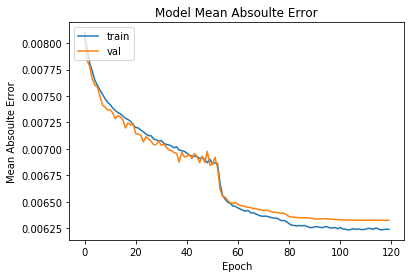

In [60]:
plt.plot(history2.history['mean_absolute_error'])
plt.plot(history2.history['val_mean_absolute_error'])
plt.title("Model Mean Absoulte Error")
plt.ylabel("Mean Absoulte Error")
plt.xlabel("Epoch")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

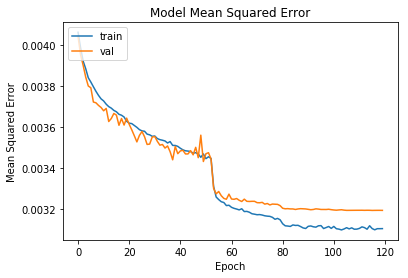

In [61]:
plt.plot(history2.history['mean_squared_error'])
plt.plot(history2.history['val_mean_squared_error'])
plt.title("Model Mean Squared Error")
plt.ylabel("Mean Squared Error")
plt.xlabel("Epoch")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

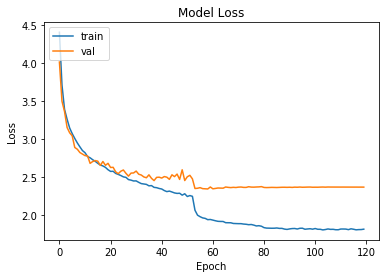

In [62]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

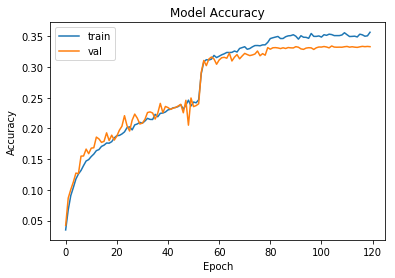

In [63]:
plt.plot(history2.history['categorical_accuracy'])
plt.plot(history2.history['val_categorical_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [64]:
for i in range(20):
    print("pred: %d, test: %d" % (prediction2[i].argmax(), test_label[i].argmax()))

pred: 36, test: 37
pred: 47, test: 45
pred: 125, test: 67
pred: 49, test: 49
pred: 136, test: 136
pred: 48, test: 48
pred: 158, test: 158
pred: 91, test: 91
pred: 151, test: 151
pred: 10, test: 11
pred: 138, test: 139
pred: 36, test: 28
pred: 20, test: 34
pred: 33, test: 34
pred: 25, test: 26
pred: 17, test: 15
pred: 36, test: 27
pred: 82, test: 89
pred: 52, test: 52
pred: 158, test: 159


In [65]:
#accuracy
acc = (prediction2.argmax(axis=1)==test_label.argmax(axis=1)).mean()*100
acc

33.38481736041393

<font color='red'>KS lipiec 2019</font>: __Metoda evaluate daje tylko 0.6% skuteczności (???)__<br>
Błąd ze względu na kolejność metryk w modelu - poprawione.

In [66]:
results = model2.evaluate(test_normalized, test_label)
print(('Dokladnosc zbioru testowego wynosi wynosi: %2.2f%s')%(results[1]*100, '%'))

12949/12949 [==============================] - 1s 78us/step
Dokladnosc zbioru testowego wynosi wynosi: 33.38%


<font color='red'>KS lipiec 2019</font>: __przygotowanie danych pod kolejne 2 wykresy testowe__

In [67]:
x = test_label.argmax(axis=1)#NMaxPoint rzeczywisty
y = prediction2.argmax(axis=1)#NMaxPoint oszacowany
z = x - y

W sytuacji idealnej spodziewamy się zestawu punktów układających się w linię prostą.

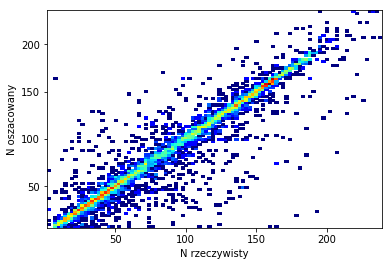

In [68]:
hist, xbins, ybins, im = plt.hist2d(x=x, y=y, bins=100, cmap='jet', norm = LogNorm())
plt.xlabel('N rzeczywisty')
plt.ylabel('N oszacowany')
plt.show()

W sytuacji idealnej spodziewamy się jednego słupka na pozycji zero:

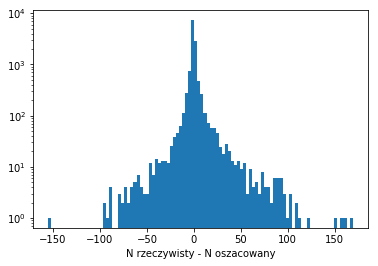

In [69]:
y, x, patches = plt.hist(z, bins = 100)
plt.yscale('log')
plt.xlabel('N rzeczywisty - N oszacowany')
plt.show()

<font color='red'>KS lipiec 2019</font>: __Poniższe informacje można wyekstrahować z powyższego histogramu poprzez dofitowanie odpowiedniej funkcji, np. Lorentza__

In [70]:
#średni błąd
mean_error = (np.absolute(prediction2.argmax(axis=1)-test_label.argmax(axis=1))).mean()
mean_error

3.5279172136844545

In [71]:
#maksymalny błąd
max_error = (np.absolute(prediction2.argmax(axis=1)-test_label.argmax(axis=1))).max()
max_error

169

In [72]:
#mediana
median = np.median((np.absolute(prediction2.argmax(axis=1)-test_label.argmax(axis=1))))
median

1.0

In [73]:
count = pd.Index(np.absolute(prediction2.argmax(axis=1)-test_label.argmax(axis=1)))
count.value_counts()

0      4323
1      3948
2      1556
3       726
4       427
5       337
6       206
7       162
8       125
9       113
10       94
11       85
12       56
13       55
16       49
15       44
14       43
17       39
19       29
20       27
18       27
23       26
24       23
21       22
25       21
26       19
22       19
29       15
38       14
36       12
       ... 
63        2
79        2
57        2
103       2
75        2
52        2
60        2
77        2
69        2
61        2
97        1
82        1
99        1
155       1
68        1
76        1
84        1
122       1
90        1
96        1
88        1
89        1
152       1
85        1
101       1
157       1
169       1
161       1
65        1
113       1
Length: 105, dtype: int64

In [74]:
# model2.save('logistic.h5')

### Zapisany model

In [75]:
model = models.load_model('logistic.h5')

In [76]:
prediction = model.predict(test_normalized)

In [77]:
#accuracy
acc = (prediction.argmax(axis=1)==test_label.argmax(axis=1)).mean()*100
acc

35.02973202563904

In [78]:
#średni błąd
mean_error = (np.absolute(prediction.argmax(axis=1)-test_label.argmax(axis=1))).mean()
mean_error

3.0580739825469148

In [79]:
#maksymalny błąd
max_error = (np.absolute(prediction.argmax(axis=1)-test_label.argmax(axis=1))).max()
max_error

149

In [80]:
#mediana
median = np.median((np.absolute(prediction.argmax(axis=1)-test_label.argmax(axis=1))))
median

1.0

In [81]:
x = pd.Index(np.absolute(prediction.argmax(axis=1)-test_label.argmax(axis=1)))
x.value_counts()

0      4536
1      3686
2      1678
3       843
4       451
5       295
6       223
7       163
8       125
9        91
10       86
11       69
12       63
14       45
16       45
13       44
15       42
17       36
18       25
19       24
21       21
20       20
26       19
23       17
27       16
44       15
22       14
37       13
24       13
29       12
       ... 
74        2
51        2
67        2
75        2
87        2
100       2
85        2
93        2
94        2
63        2
65        2
72        1
95        1
57        1
92        1
71        1
102       1
86        1
149       1
133       1
124       1
84        1
97        1
76        1
115       1
91        1
83        1
66        1
113       1
99        1
Length: 97, dtype: int64

<font color='red'> KS lipiec 2019</font>: Powyższą analizę proszę opisać w pracy (nazwijmy ją etap 1).
Poniżej proponuję dokonać następującej inżynierii danych (nazwijmy to etapem 2, który również znajdzie się w Pańskiej pracy). Proszę wprowadzać zmiany stopniowo, tzn. najpierw punkt 1 i sprawdzić jak wpłynęło to na wynik, potem punkt 2 itd.
1. Proszę nie normalizować zmiennej q.
2. Proszę pominąć cechy, od których NMaxPoint jest niezależny (te "pionowe" na histogramach 2D, np. px, py).
3. Cechy p i pz są redudantne, proszę wybrać tylko jedną z nich.
4. Dla cech symetrycznych względem zera (np: pLastX), proszę obliczyc wartość bezwględną, a dopiero potem znormalizować.


<font color='red'> KS lipiec 2019</font>: 
Trzecim etapem bedzie rozbicie NMaxPointa na poszczegolne komory detektora (otrzyma Pan nowy zestaw danych) i sprawdzenie, która komora generuje największy błąd.
Czwartym etapem będzie (opcjonalnie) zaimplementowanie metody klasycznej,